* In this assignment you will be building the **Encoder** part of the Transformer architecture.
* You will be using the **PyTorch** framework to implement the following components
  * Encoder Layer that contains
    * Multi-Head Attention (MHA) Module
    * Position-wise Feed Forward Neural Network

  * Output layer that takes the encoder output and predicts the token_ids.

  * Optionally, study whether adding positional information is helpful.
  
* **DO NOT** USE Built-in **TRANSFORMER LAYERS** as it affects the reproducibility.

* You will be given with a configuration file that contains information on various hyperparameters such as embedding dimension, vocabulary size,number heads and so on

* Use ReLU activation function and Stochastic Gradient Descent optimizer
* Here are a list of helpful Pytorch functions (does not mean you have to use all of them) for this and subsequent assignments
  * [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html#torch-matmul)
  * [torch.bmm](https://pytorch.org/docs/stable/generated/torch.bmm.html)
  * torch.swapdims
  * torch.unsqueeze
  * torch.squeeze
  * torch.argmax
  * [torch.Tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)
  * [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
  * [torch.nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)
  * torch.nn.Linear
  * torch.nn.LayerNorm
  * torch.nn.ModuleList
  * torch.nn.Sequential
  * [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
  
* Important: **Do not** set any global seeds.

* Helpful resources to get started with

 * [Annotated Transformers](https://nlp.seas.harvard.edu/annotated-transformer/)
 * [PyTorch Source code of Transformer Layer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)



# Import

In [37]:
import torch
from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

from  pprint import pprint
from yaml import safe_load
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import math
import time
import copy

# Configuration

In [38]:
#do not edit this cell
config_url = "https://raw.githubusercontent.com/Arunprakash-A/LLM-from-scratch-PyTorch/main/config_files/enc_config.yml"
response = requests.get(config_url)
config = response.content.decode("utf-8")
config = safe_load(config)
pprint(config)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 10},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


In [39]:
#do not edit this cell
vocab_size = config['input']['vocab_size']
batch_size = config['input']['batch_size']
seq_len = config['input']['seq_len']
embed_dim = config['input']['embed_dim']
print(f' Vocab Size {vocab_size}, Batch size {batch_size}, sequence length {seq_len}, Embedding dimension {embed_dim}')

 Vocab Size 10, Batch size 10, sequence length 8, Embedding dimension 32


* Here, you are directly given with the token ids
* Assume that length of all sequences are equal to the context length (T) (so that we do not need to bother about padding shorter sequences while batching)

In [40]:
# do not edit this cell
data_url = 'https://github.com/Arunprakash-A/LLM-from-scratch-PyTorch/raw/main/config_files/w1_input_tokens'
r = requests.get(data_url)
token_ids = torch.load(BytesIO(r.content))
print(token_ids)

tensor([[5, 7, 5, 6, 3, 8, 7, 5],
        [7, 2, 7, 1, 2, 1, 1, 7],
        [1, 0, 0, 3, 6, 3, 0, 8],
        [5, 0, 2, 8, 6, 5, 5, 3],
        [3, 5, 4, 8, 5, 0, 7, 3],
        [8, 6, 7, 4, 4, 4, 0, 1],
        [5, 8, 1, 0, 1, 1, 0, 3],
        [1, 7, 8, 8, 0, 5, 3, 7],
        [7, 7, 1, 4, 5, 6, 7, 0],
        [1, 7, 2, 8, 3, 0, 0, 4]])


<ipython-input-40-0fefa6fcf57f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  token_ids = torch.load(BytesIO(r.content))


# Building the sub-layers

In [41]:
# do not edit this cell
dq = torch.tensor(config['model']['dq'])
dk = torch.tensor(config['model']['dk'])
dv = torch.tensor(config['model']['dv'])
dmodel = embed_dim
heads = torch.tensor(config['model']['n_heads'])
d_ff = config['model']['d_ff']

##Multi-Head Attention

 * Be mindful when using `torch.matmul`
 * Ensure that you understood what is being computed (because matrix product is not commutative)
 * Randomly initialize the parameters using normal distribution with the following seed values
  * $W_Q:$(seed=43)
  * $W_K:$(seed=44)
  * $W_V:$(seed=45)
  * $W_O:$(seed=46)

In [54]:
class MHA(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,heads):
    super(MHA,self).__init__()
    self.dmodel = dmodel
    self.dq = dq
    self.dk = dk
    self.dv = dv
    self.heads = heads
    # initializing weight for dQ,dK,dV using normal distribution
    torch.manual_seed(43)
    self.WQ = nn.Parameter(torch.randn(dq*heads,dmodel))
    torch.manual_seed(44)
    self.WK = nn.Parameter(torch.randn(dk*heads,dmodel))
    torch.manual_seed(45)
    self.WV = nn.Parameter(torch.randn(dv*heads,dmodel))
    torch.manual_seed(46)
    self.WO = nn.Parameter(torch.randn(dmodel,dv*heads))
  # your method definitions go here (if you want to)

  def forward(self,x):
    '''
    Input: Size [BSxTxdmodel]
    Output: Size[BSxTxdmodel]
    '''
    Q = torch.matmul(x, self.WQ.T)
    K = torch.matmul(x, self.WK.T)
    V = torch.matmul(x, self.WV.T)


    dk = self.dk.clone().detach().float()
    scores = torch.matmul(Q, K.transpose(-2,-1))/torch.sqrt(dk)

    # Apply softmax to obtain attention weights
    attn_weights = F.softmax(scores, dim=-1)

    out = torch.matmul(attn_weights,V)
    out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.heads * self.dv)
    out = torch.matmul(out, self.WO)
    print(out)
    return out

## Pointwise FFN

* Randomly initialize the parameters using normal distribution with the following seed values
  * $W_{1}:$(seed=47)
  * $W_2:$(seed=48)  

In [63]:
class FFN(nn.Module):
  def __init__(self,dmodel,d_ff,layer=0):
    super(FFN,self).__init__()
    #your code goes here
    torch.manual_seed(47)
    self.W1 = nn.Parameter(torch.randn(dmodel,d_ff))

    torch.manual_seed(48)
    self.W2 = nn.Parameter(torch.randn(d_ff,dmodel))

    self.relu = nn.ReLU()



  def forward(self,x):
    '''
    input: size [BSxTxdmodel]
    output: size [BSxTxdmodel]
    '''
    #your code goes here
    out1 = torch.matmul(x,self.W1)
    out2 = self.relu(out1)
    out = torch.matmul(out2,self.W2)


    return out

## Output Layer

* Randomly initialize the linear layer
 * $W_L:$(seed=49)


In [64]:
class OutputLayer(nn.Module):

  def __init__(self,dmodel,vocab_size):
    super(OutputLayer,self).__init__()
    # your code goes here
    torch.manual_seed(49)
    self.WL = nn.Linear(dmodel,vocab_size,bias=True)


  def forward(self,representations):
    '''
    input: size [bsxTxdmodel]
    output: size [bsxTxvocab_size]
    Note: Do not apply the softmax. Just return the output of linear transformation
    '''
    out = self.WL(representations)
    return out

## Encoder Layer

In [65]:
class EncoderLayer(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,d_ff,heads):
    super(EncoderLayer,self).__init__()
    self.mha = MHA(dmodel,dq,dk,dv,heads)
    self.layer_norm_mha = torch.nn.LayerNorm(dmodel)
    self.layer_norm_ffn = torch.nn.LayerNorm(dmodel)
    self.ffn = FFN(dmodel,d_ff)

  def forward(self,x):
    out_1 = self.mha(x)
    out_2 = out_1+x
    out_3 = self.layer_norm_mha(out_2)
    out_4 = self.ffn(out_3)
    out_5 = out_3 + out_4
    out = self.layer_norm_ffn(out_5)

    # do a forward pass

    return out

## Model with one encoder layer

 * The encoders' forward function accepts the token_ids as input
 * Generate the embeddings for the token ids by initializing the emebedding weights from normal distribution by setting the seed value to 50
 * Use `torch.nn.Embed()` to generate required embeddings

In [66]:
class Embed(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Embed, self).__init__()
        # Set the random seed for reproducibility
        torch.manual_seed(50)

        # Initialize embedding layer
        self.embed = nn.Embedding(vocab_size, embed_dim)

        # Initialize embedding weights with normal distribution
        with torch.no_grad():
            self.embed.weight.copy_(torch.randn(vocab_size, embed_dim))

    def forward(self, x):
        # Lookup the embeddings for the token_ids
        out = self.embed(x)
        return out

In [80]:
class Encoder(nn.Module):

  def __init__(self,vocab_size,embed_dim,dq,dk,dv,d_ff,heads,num_layers=1):
    super(Encoder,self).__init__()

    self.embed = Embed(vocab_size, embed_dim)

    encoder_layer = EncoderLayer(dmodel, dq,dk,dv,d_ff,heads)

    self.encoder_layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])

    self.output_layer = OutputLayer(dmodel,vocab_size)


  def forward(self,x):
    '''
    The input should be tokens ids of size [BS,T]
    '''
    out = self.embed(x) # get the embeddings of the tokens

    for layer in self.encoder_layers:
            #print(i, layer)
            out = layer(out)

    out =  self.output_layer(out)# get the logits

    return out

In [81]:
model = Encoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=1)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training the model

 * Train the model for 30 epochs and compute the loss

In [89]:
import matplotlib.pyplot as plt

def train(token_ids, model, optimizer, criterion, epochs=1):
    loss_values = []

    for epoch in range(epochs):
        model.train()

        # Forward pass
        out = model(token_ids)

        # Reshape output and target for loss calculation
        batch_size, seq_len, vocab_size = out.size()
        out = out.view(-1, vocab_size)
        target = token_ids.view(-1)

        # Compute loss
        loss = criterion(out, target)
        loss_values.append(loss.item())

        # Print loss every 2 epochs
        if epoch % 2 == 0:
            print(f'Epoch {epoch}, loss: {loss.item()}')

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update parameters

    # Plotting loss values
    plt.plot(range(epochs), loss_values, label='Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)  # Optional: Add a grid for better visualization
    plt.show()

    # Final loss output
    print(f'Final Loss after training for {epochs} epochs is {loss.item()}')

tensor([[[ 4.3137e+00,  7.7646e+00,  2.5133e+01,  ..., -9.6063e+00,
          -1.0279e+01, -2.8844e+01],
         [ 2.0041e+00, -1.2024e+01,  6.8320e+00,  ...,  3.0749e+01,
          -1.2292e+01, -7.2376e+00],
         [-5.1787e+01,  4.6306e+00, -6.0448e+01,  ..., -3.7170e+01,
          -3.6967e+00,  2.3297e+01],
         ...,
         [ 1.5970e+01,  3.4199e+01,  6.9944e+01,  ...,  1.2110e+01,
          -1.1499e+01, -8.9128e+00],
         [-2.7471e+00, -3.4273e+00, -3.4894e+01,  ...,  1.2406e+00,
           1.5104e+01,  2.5135e+01],
         [-9.7987e+00,  1.1867e+01, -2.1645e+01,  ..., -1.0970e+01,
           1.5117e+00,  3.1826e+00]],

        [[-1.9664e+01,  1.9946e+01, -3.5387e+01,  ..., -7.8059e+00,
           2.1165e+01,  2.8288e+01],
         [-2.0478e-01, -2.8633e+01,  4.2522e+01,  ...,  2.2379e+01,
          -4.3567e+01,  2.0989e+00],
         [ 2.6537e+01, -2.5856e+01,  1.7799e+01,  ..., -1.0499e+01,
           6.3958e+00, -2.6807e+01],
         ...,
         [-5.1717e+01,  1

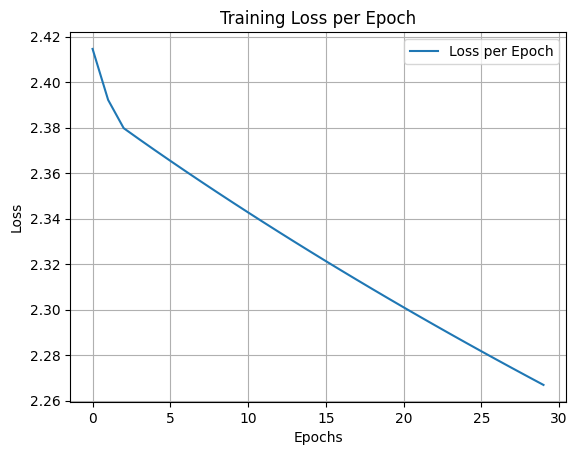

Final Loss after training for 30 epochs is 2.26690936088562


In [90]:
train(token_ids, model, optimizer, criterion, epochs=30 )

# Inference

In [83]:
with torch.inference_mode():
  predictions = model(token_ids) # predict the labels
  predicted_labels = predictions.argmax(dim=-1)

correct_predictions = (token_ids == predicted_labels)  # Shape: [BS, T]
print(torch.count_nonzero(correct_predictions))

tensor([[[ 4.3137e+00,  7.7646e+00,  2.5133e+01,  ..., -9.6063e+00,
          -1.0279e+01, -2.8844e+01],
         [ 2.0041e+00, -1.2024e+01,  6.8320e+00,  ...,  3.0749e+01,
          -1.2292e+01, -7.2376e+00],
         [-5.1787e+01,  4.6306e+00, -6.0448e+01,  ..., -3.7170e+01,
          -3.6967e+00,  2.3297e+01],
         ...,
         [ 1.5970e+01,  3.4199e+01,  6.9944e+01,  ...,  1.2110e+01,
          -1.1499e+01, -8.9128e+00],
         [-2.7471e+00, -3.4273e+00, -3.4894e+01,  ...,  1.2406e+00,
           1.5104e+01,  2.5135e+01],
         [-9.7987e+00,  1.1867e+01, -2.1645e+01,  ..., -1.0970e+01,
           1.5117e+00,  3.1826e+00]],

        [[-1.9664e+01,  1.9946e+01, -3.5387e+01,  ..., -7.8059e+00,
           2.1165e+01,  2.8288e+01],
         [-2.0478e-01, -2.8633e+01,  4.2522e+01,  ...,  2.2379e+01,
          -4.3567e+01,  2.0989e+00],
         [ 2.6537e+01, -2.5856e+01,  1.7799e+01,  ..., -1.0499e+01,
           6.3958e+00, -2.6807e+01],
         ...,
         [-5.1717e+01,  1

* See how many labels are correctly predicted

In [91]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 13066


In [92]:
total_num_parameters = 0

# Loop through all named parameters in the model
for name, parameter in model.named_parameters():
    # Get the number of elements in the parameter tensor
    num_params = parameter.numel()
    # Print the parameter name and number of elements
    print(f"Parameter name: {name}, Number of parameters: {num_params}")
    # Add this to the total count
    total_num_parameters += num_params

# Print the total result
print('Total number of parameters in the model, including the embedding layer, is:', total_num_parameters)


Parameter name: embed.embed.weight, Number of parameters: 320
Parameter name: encoder_layers.0.mha.WQ, Number of parameters: 1024
Parameter name: encoder_layers.0.mha.WK, Number of parameters: 1024
Parameter name: encoder_layers.0.mha.WV, Number of parameters: 1024
Parameter name: encoder_layers.0.mha.WO, Number of parameters: 1024
Parameter name: encoder_layers.0.layer_norm_mha.weight, Number of parameters: 32
Parameter name: encoder_layers.0.layer_norm_mha.bias, Number of parameters: 32
Parameter name: encoder_layers.0.layer_norm_ffn.weight, Number of parameters: 32
Parameter name: encoder_layers.0.layer_norm_ffn.bias, Number of parameters: 32
Parameter name: encoder_layers.0.ffn.W1, Number of parameters: 4096
Parameter name: encoder_layers.0.ffn.W2, Number of parameters: 4096
Parameter name: output_layer.WL.weight, Number of parameters: 320
Parameter name: output_layer.WL.bias, Number of parameters: 10
Total number of parameters in the model, including the embedding layer, is: 13066

* The loss by now should be about 2.39 and the number of correct predictions should be about 37

# Encoder with N Layers

  * The intialized parameters in all layers are identical
  * use ModuleList to create **deep-copies** of encoder layer

In [74]:
import copy

* Train the stack of encoder layers with `num_layers=2` for the same 30 epochs

In [102]:
model1 = Encoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=2)
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model.parameters(), lr=0.01)

Streaming output truncated to the last 5000 lines.
         [ 9.7459e+00,  2.3212e-02, -6.9997e+01,  ..., -4.5853e+01,
           4.5554e+01,  1.8109e+01],
         [ 2.4818e+01, -4.9339e-01,  2.5165e+01,  ...,  4.3032e+01,
           7.1128e+00, -2.0158e+01],
         ...,
         [-8.9560e+00, -2.9838e+01,  4.7267e+01,  ...,  1.7396e+01,
          -8.1946e+01,  3.7942e+00],
         [-8.5257e+00, -2.0855e+00, -3.8249e+01,  ..., -6.0925e+01,
           4.6603e+01,  6.3548e+01],
         [-6.1727e+00,  3.3432e+01, -2.4050e+01,  ..., -2.1983e+01,
           7.1790e+00,  3.6876e+00]],

        ...,

        [[ 2.4215e+01, -1.6729e+01,  5.0875e+01,  ..., -5.5210e+00,
          -4.2774e+01, -2.6769e+01],
         [-1.7057e+01,  2.5731e+01, -3.6859e+01,  ...,  6.0606e+00,
           3.8342e+01, -2.6106e+01],
         [ 5.6445e+01, -3.4981e+01,  4.0253e+01,  ...,  4.3120e+01,
          -1.6199e+01, -3.7542e+01],
         ...,
         [-1.2406e+01, -4.4842e+01,  4.2706e+01,  ...,  1.9647e+0

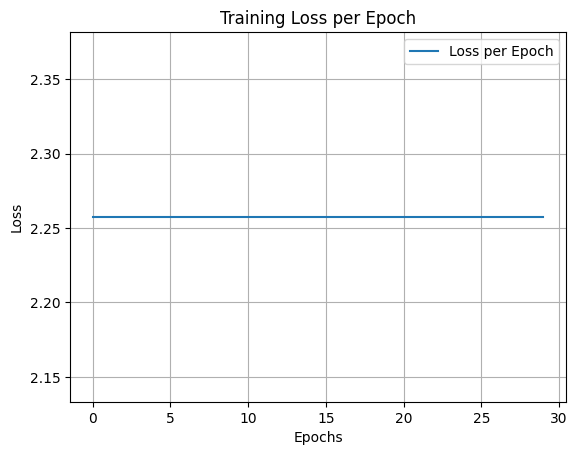

Final Loss after training for 30 epochs is 2.257434129714966


In [103]:
train(token_ids, model1, optimizer1, criterion, epochs=30)

In [104]:
with torch.inference_mode():
    # Get logits from the model
    predictions = model1(token_ids)  # Shape: [BS, T, vocab_size]

    # Get the predicted labels by applying argmax along the vocab dimension
    predicted_labels = predictions.argmax(dim=-1)  # Shape: [BS, T]

correct_predictions = (token_ids == predicted_labels)  # Shape: [BS, T]
print(torch.count_nonzero(correct_predictions))


tensor([[[ 4.3137e+00,  7.7646e+00,  2.5133e+01,  ..., -9.6063e+00,
          -1.0279e+01, -2.8844e+01],
         [ 2.0041e+00, -1.2024e+01,  6.8320e+00,  ...,  3.0749e+01,
          -1.2292e+01, -7.2376e+00],
         [-5.1787e+01,  4.6306e+00, -6.0448e+01,  ..., -3.7170e+01,
          -3.6967e+00,  2.3297e+01],
         ...,
         [ 1.5970e+01,  3.4199e+01,  6.9944e+01,  ...,  1.2110e+01,
          -1.1499e+01, -8.9128e+00],
         [-2.7471e+00, -3.4273e+00, -3.4894e+01,  ...,  1.2406e+00,
           1.5104e+01,  2.5135e+01],
         [-9.7987e+00,  1.1867e+01, -2.1645e+01,  ..., -1.0970e+01,
           1.5117e+00,  3.1826e+00]],

        [[-1.9664e+01,  1.9946e+01, -3.5387e+01,  ..., -7.8059e+00,
           2.1165e+01,  2.8288e+01],
         [-2.0478e-01, -2.8633e+01,  4.2522e+01,  ...,  2.2379e+01,
          -4.3567e+01,  2.0989e+00],
         [ 2.6537e+01, -2.5856e+01,  1.7799e+01,  ..., -1.0499e+01,
           6.3958e+00, -2.6807e+01],
         ...,
         [-5.1717e+01,  1

* Now, the loss value should be about 1.9 and the number of correct preditions is about 38

## Count Number of Parameters

In [107]:
total_num_parameters = 0

# Loop through all named parameters in the model
for name, parameter in model1.named_parameters():
    # Get the number of elements in the parameter tensor
    num_params = parameter.numel()
    # Print the parameter name and number of elements
    print(f"Parameter name: {name}, Number of parameters: {num_params}")
    # Add this to the total count
    total_num_parameters += num_params

# Print the total result
print('Total number of parameters in the model, including the embedding layer, is:', total_num_parameters)

Parameter name: embed.embed.weight, Number of parameters: 320
Parameter name: encoder_layers.0.mha.WQ, Number of parameters: 1024
Parameter name: encoder_layers.0.mha.WK, Number of parameters: 1024
Parameter name: encoder_layers.0.mha.WV, Number of parameters: 1024
Parameter name: encoder_layers.0.mha.WO, Number of parameters: 1024
Parameter name: encoder_layers.0.layer_norm_mha.weight, Number of parameters: 32
Parameter name: encoder_layers.0.layer_norm_mha.bias, Number of parameters: 32
Parameter name: encoder_layers.0.layer_norm_ffn.weight, Number of parameters: 32
Parameter name: encoder_layers.0.layer_norm_ffn.bias, Number of parameters: 32
Parameter name: encoder_layers.0.ffn.W1, Number of parameters: 4096
Parameter name: encoder_layers.0.ffn.W2, Number of parameters: 4096
Parameter name: encoder_layers.1.mha.WQ, Number of parameters: 1024
Parameter name: encoder_layers.1.mha.WK, Number of parameters: 1024
Parameter name: encoder_layers.1.mha.WV, Number of parameters: 1024
Parame

## (Optional) Positional Encoding

 * We now use the positional embedding as defined in the [paper](https://arxiv.org/pdf/1706.03762v1.pdf) (differs a bit from the lecture).
 * Note that, the positional encoding for each position is fixed (not a learnable parameter)
 * However, we add this with the raw_embeddings which are learnable.
 * Therefore, it is important to create a class definition for PE and register PE parameters in the buffer (in case we move the model to GPU)
 * Just create a matrix of same size of input and add it to the embeddings

In [108]:
class PositionalEncoding(nn.Module):
    "Positional Encoding using sine and cosine functions."

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create a matrix to hold positional encodings
        pe = torch.zeros(max_len, d_model)

        # Position indices (shape: [max_len, 1])
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Dividing terms: 10000^(2i / d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices (2i) and cosine to odd indices (2i+1)
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices

        # Register the positional encodings as a buffer (non-trainable)
        self.register_buffer("pe", pe.unsqueeze(0))  # Shape: [1, max_len, d_model]

    def forward(self, x):
        # Add positional encoding to the input embeddings (x should be of size [batch_size, seq_len, d_model])
        x = x + self.pe[:, :x.size(1), :]
        return x
